
--- Scenario 1 vs Scenario 2 with SM Tax Savings ---


,Rental Appreciation %,SM 4% Diff ($000),SM 4% Tax Save ($000),SM 5% Diff ($000),SM 5% Tax Save ($000),SM 6% Diff ($000),SM 6% Tax Save ($000),SM 7% Diff ($000),SM 7% Tax Save ($000),SM 8% Diff ($000),SM 8% Tax Save ($000)
0,0,-151.5,50.0,-188.7,50.0,-229.2,50.0,-273.2,50.0,-321.2,50.0
1,1,-46.9,50.0,-84.1,50.0,-124.5,50.0,-168.6,50.0,-216.6,50.0
2,2,67.5,50.0,30.3,50.0,-10.2,50.0,-54.2,50.0,-102.2,50.0
3,3,192.4,50.0,155.2,50.0,114.8,50.0,70.7,50.0,22.7,50.0
4,4,328.7,50.0,291.6,50.0,251.1,50.0,207.0,50.0,159.1,50.0
5,5,477.4,50.0,440.2,50.0,399.7,50.0,355.7,50.0,307.7,50.0
6,6,639.3,50.0,602.2,50.0,561.7,50.0,517.6,50.0,469.7,50.0
7,7,815.6,50.0,778.5,50.0,738.0,50.0,693.9,50.0,646.0,50.0


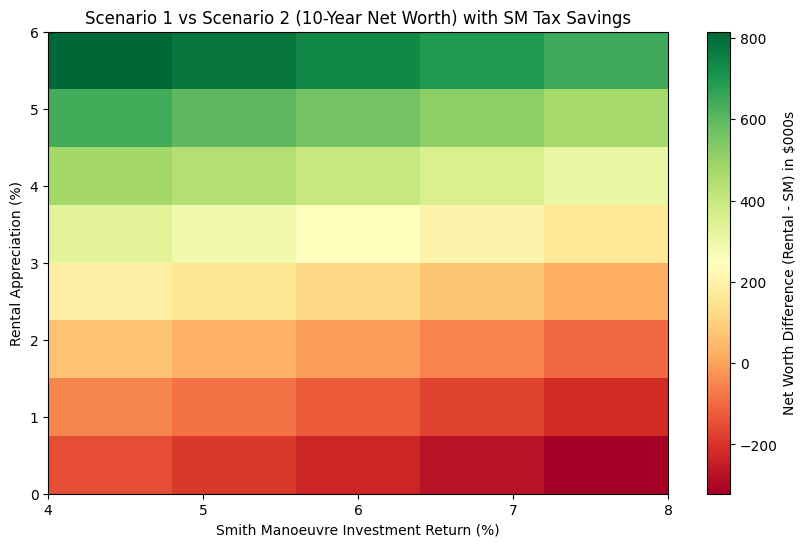

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Constants ---
years = 10
purchase_price = 1_300_000  # Principal Residence
rental_price = 1_000_000    # Investment Property
down_pr1, down_pr2 = 0.10, 0.20
rate = 0.0395
amort_years = 30
tax_rate = 0.50
sm_return_range = np.arange(0.04, 0.09, 0.01)   # 4% to 8%
rental_appreciation_range = np.arange(0.00, 0.07, 0.01) # 0% to 6%
pr_appreciation = 0.03
annual_deductible_interest = 10_000  # approx yearly interest eligible for SM tax deduction
income_start = 250_000
income_growth = 0.03  # 3% per year
rate_schedule = {
    1: 0.0395,  # Year 1
    3: 0.0450,  # Year 3
    5: 0.0500   # Year 5
}

# --- Mortgage Balance Function ---
def mortgage_balance(principal, rate, amort_years, years):
    r = rate / 12
    n = amort_years * 12
    pmt = principal * r / (1 - (1 + r)**-n)
    bal = principal * (1 + r)**(years*12) - pmt * ((1 + r)**(years*12) - 1) / r
    return bal

# --- Mortgage Balance with Variable Rates ---
def mortgage_balance_schedule(principal, amort_years, rate_schedule):
    """
    principal: initial mortgage
    amort_years: total amortization in years
    rate_schedule: dict {year: rate}, e.g., {1:0.0395,3:0.045,5:0.05}
    """
    balance = principal
    for y in range(1, amort_years+1):
        # Determine rate for this year
        applicable_years = [yr for yr in rate_schedule.keys() if yr <= y]
        if applicable_years:
            rate = rate_schedule[max(applicable_years)]
        else:
            rate = list(rate_schedule.values())[0]  # default to first rate if year < min(rate_schedule)
        
        # Annual payment based on 12 months
        r_month = rate / 12
        n_months = (amort_years - y + 1) * 12  # remaining months
        pmt = balance * r_month / (1 - (1 + r_month)**-n_months)
        balance = balance * (1 + r_month)**12 - pmt * ((1 + r_month)**12 - 1) / r_month
    return balance


# --- Scenario 1: PR + Rental ---
def scenario1(rental_appreciation):
    pr_future = purchase_price * ((1 + pr_appreciation)**years)
    rental_future = rental_price * ((1 + rental_appreciation)**years)
    bal_pr = mortgage_balance(purchase_price*(1-down_pr1), rate, amort_years, years)
    bal_rental = mortgage_balance(rental_price*0.8, rate, amort_years, years)
    equity = pr_future - bal_pr + (rental_future - bal_rental)
    return equity

# --- Scenario 2: PR + Smith Manoeuvre ---
def scenario2(sm_return):
    pr_future = purchase_price * ((1 + pr_appreciation)**years)
    bal_pr = mortgage_balance(purchase_price*(1-down_pr2), rate, amort_years, years)
    invest_growth = income_start * ((1 + sm_return)**years)
    # Calculate tax savings year by year based on income growth
    tax_savings = 0
    income = income_start
    for y in range(years):
        yearly_deduction = annual_deductible_interest
        yearly_tax_save = yearly_deduction * tax_rate
        tax_savings += yearly_tax_save
        income *= (1 + income_growth)  # increase income for next year
    
    equity = pr_future - bal_pr + invest_growth + tax_savings
    return equity, tax_savings

# --- Build Sensitivity Table ---
data = []
for r_app in rental_appreciation_range:
    row = {"Rental Appreciation %": int(r_app*100)}
    for sm_ret in sm_return_range:
        s1 = scenario1(r_app)
        s2, tax_saving = scenario2(sm_ret)
        diff = s1 - s2  # positive = rental better, negative = SM better
        row[f"SM {int(sm_ret*100)}% Diff ($000)"] = round(diff/1000,1)
        row[f"SM {int(sm_ret*100)}% Tax Save ($000)"] = round(tax_saving/1000,1)
    data.append(row)

df = pd.DataFrame(data)
print("\n--- Scenario 1 vs Scenario 2 with SM Tax Savings ---")
display(df)

# --- Heatmap ---
plt.figure(figsize=(10,6))
sm_diff_cols = [col for col in df.columns if "Diff" in col]
im = plt.imshow(df[sm_diff_cols].values, cmap="RdYlGn", aspect="auto", 
                extent=[4, 8, 0, 6], origin="lower")
plt.colorbar(im, label="Net Worth Difference (Rental - SM) in $000s")
plt.xticks(np.arange(4, 9, 1))
plt.yticks(np.arange(0, 7, 1))
plt.xlabel("Smith Manoeuvre Investment Return (%)")
plt.ylabel("Rental Appreciation (%)")
plt.title("Scenario 1 vs Scenario 2 (10-Year Net Worth) with SM Tax Savings")
plt.show()
